### (b) Approach to manage and process the data

The housing market dataset provide the name of the neighbourhood as well as the latitude and longitude of the observations. Hence, aggregated housing market data on the neighbourhood level can be merged to the airbnb dataset. To get a finer granularity we are going to define circles of a given distance and to **aggregate the housing market data** within a circle or extract the information of the **the nearest neighbour**. The crime data and the airbnb data can only be merged by the neighbourhood. <br>

The following dataset are created: <br>

**Airbnb** <br>
A ``DataFrame`` with the columns `Air_accommodates`, `Air_bathrooms`, `Air_bedrooms`, `Air_beds`, `Air_guests_inluded` and `Air_log_price` without outliers is the basis for the aggregation. After removing the observations that have at least one outlier 17'360 observation remains from originally 22'331 observations. 
- *airbnb_agg_suburbs_wo_outliers_XX*: Average, sum or number of observations of airbnb data without outliers either aggregated by neighbourhood and room type or by neighbourhood and property type.
- *airbnb_agg_XXm_wo_outliers_XX*: Dictionary of `DataFrames` with keys 'mean', 'median' and 'count'. The log airbnb prices and the other variables are aggregated by the method indicated as 'key'. The aggregation is done either for house type or property type.
- *airbnb_nearest_wo_outliers_XX*: The extracted log airbnb price and the values of the other variables of the nearest neighbours. The aggregation is done either for room type or property type. <br>

**Housing**
The variables of interest are `House_log_price`, `House_rooms`, `House_distance`, `House_bedroom2`, `House_bathroom`, and `House_landsize`. From originally 9'386 observations (after cleaning) 7'677 observations are left after removing outliers.
- *housing_agg_wo_outliers*: Averaged housing market data without outliers by suburb.
- *housing_agg_XXm_wo_outliers*: Dictionary of `DataFrames` with keys 'mean', 'median' and 'count'. The log airbnb prices and the other variables are aggregated by the method indicated as 'key'.
- *airbnb_nearest_wo_outliers*: The extracted log house prices and the values of the other variables of the nearest neighbours. <br>

**Crimes**
`Crime_lga_rate_per_100000_population`,`Crime_local_government_area` and `Crime_offence_division` are aggregated by the local government area.
- *crimes_agg*: Averaged values.
- *crimes_agg_median*: Median of the aggregated values. 

In a first step the property type is re-grouped so that the information from the house dataset can be later merged to it.

In [71]:
tmp = airbnb_cleaned_df.loc[:, ['Air_accommodates', 'Air_bathrooms', 'Air_bedrooms',
                               'Air_beds', 'Air_guests_included', 'Air_log_price',
                               'Air_latitude', 'Air_longitude', 'Air_room_type',
                               'Air_id', 'Air_neighbourhood_cleansed',
                               'Air_property_type']]

tmp['Air_property_type_2'] = 'Other'
tmp.loc[tmp.Air_property_type.isin(['House', 'Cottage', 'Villa']), 'Air_property_type_2'] = 'House_Cottage_Villa'
tmp.loc[tmp.Air_property_type.isin(['Apartment', 'Condominium']), 'Air_property_type_2'] = 'Apartment_Condominium'
tmp.loc[tmp.Air_property_type.isin(['Townhouse']), 'Air_property_type_2'] = 'Townhouse'

quantiles = tmp.quantile([.25, .75])
iqr = quantiles.iloc[1, :] - quantiles.iloc[0, :]
upper_bounds = quantiles.iloc[1, :] + 1.5*iqr
lower_bounds = quantiles.iloc[0, :] - 1.5*iqr
upper_bounds

airbnb_sub_wo_outliers = tmp.loc[(tmp.Air_accommodates <= upper_bounds[0]) & (tmp.Air_accommodates >= lower_bounds[0]) &
                        (tmp.Air_bathrooms <= upper_bounds[1]) & (tmp.Air_bathrooms >= lower_bounds[1]) & 
                        (tmp.Air_bedrooms <= upper_bounds[2]) & (tmp.Air_bedrooms >= lower_bounds[2]) & 
                        (tmp.Air_beds <= upper_bounds[3]) & (tmp.Air_beds >= lower_bounds[3]) & 
                        (tmp.Air_guests_included <= upper_bounds[4]) & (tmp.Air_guests_included >= lower_bounds[4]) &
                        (tmp.Air_log_price <= upper_bounds[5]) & (tmp.Air_log_price >= lower_bounds[5]), :]
airbnb_sub_wo_outliers.shape

(17360, 13)

In [72]:
tmp = housing_cleaned_df.loc[:, ['House_log_price', 'House_rooms', 'House_distance', 'House_bedroom2', 
                                 'House_bathroom', 'House_landsize',
                                'House_suburb', 'House_type', 'House_latitude', 'House_longitude']]
quantiles = tmp.quantile([.25, .75])
iqr = quantiles.iloc[1, :] - quantiles.iloc[0, :]
upper_bounds = quantiles.iloc[1, :] + 1.5*iqr
lower_bounds = quantiles.iloc[0, :] - 1.5*iqr
upper_bounds

housing_sub_wo_outliers = tmp.loc[(tmp.House_log_price <= upper_bounds[0]) & (tmp.House_log_price >= lower_bounds[0]) &
                        (tmp.House_rooms <= upper_bounds[1]) & (tmp.House_rooms >= lower_bounds[1]) & 
                        (tmp.House_distance <= upper_bounds[2]) & (tmp.House_distance >= lower_bounds[2]) & 
                        (tmp.House_bedroom2 <= upper_bounds[3]) & (tmp.House_bedroom2 >= lower_bounds[3]) & 
                        (tmp.House_bathroom <= upper_bounds[4]) & (tmp.House_bathroom >= lower_bounds[4]) &
                        (tmp.House_landsize <= upper_bounds[5]) & (tmp.House_landsize >= lower_bounds[5]), :]
housing_sub_wo_outliers.shape

(7677, 10)

In [73]:
housing_cleaned_df.shape

(9386, 23)

In [74]:
# previously cell 12
def polynomial(x, y, deg):
    
    """
    args:
        x: ``DataFrame``
            The endogeneous variable(s)
        y: ``Series``
            The exogeneous variable
        deg: ``int``
            The degree of the polynomial
    
    returns:
         A dictionary containing the DataFrame with he predicted y and x^1 sorted by x^1 (key 'data') and
         a the coefficients as a string (key 'coef').
    """
    
    data = pd.DataFrame({'y': y, 'x': x})
    data.dropna(how='any', inplace=True)
    
    polynomial_features= PolynomialFeatures(degree=deg)
    x_poly = polynomial_features.fit_transform(data.loc[:, 'x'].values.reshape(-1,1))

    model = LinearRegression(fit_intercept=False)
    model.fit(x_poly, data.loc[:, 'y'])
    y_poly_pred = model.predict(x_poly)
    values = pd.DataFrame(np.c_[y_poly_pred, x_poly])
    values.columns = ['y_pred'] + ['x_' + str(i) for i in range(deg+1)] 
    values.sort_values(by='x_1', inplace=True)
    r2 = r2_score(data.loc[:, 'y'], y_poly_pred)
    
    return {'data': values.loc[:, ['y_pred', 'x_1']], 
            'coef': str([round(el,1) for el in model.coef_]).strip('[]'),
            'r2': r2}

**Reindexing the datasets**

We have to reindex the datasets so that everything works fine.

In [75]:
# modified
airbnb_cleaned_df.index = range(airbnb_cleaned_df.shape[0])
airbnb_sub_wo_outliers.index = range(airbnb_sub_wo_outliers.shape[0])
housing_cleaned_df.index = range(housing_cleaned_df.shape[0])
housing_sub_wo_outliers.index = range(housing_sub_wo_outliers.shape[0])

**AIRBNB DATA**

We start by aggregating the airbnb data. We aggregate / prepare the data in three ways as already explained above:
- by suburbs
- w.r.t a defined radius
- the nearest neighbour (no aggregation)

**Aggregation by suburbs**

*Room type*

First, we distinguish between the different room types 'Entire home/apt', 'Private room' and 'Shared room'.

In [76]:
airbnb_agg_wo_outliers = air.aggregate_data(airbnb_sub_wo_outliers, 
                                            ['Air_accommodates', 'Air_bathrooms', 'Air_bedrooms',
                                            'Air_beds', 'Air_guests_included', 'Air_log_price'], 
                                            ['Air_neighbourhood_cleansed'], agg_fun ='mean',
                                            classifier='Air_room_type')
airbnb_agg_wo_outliers

,Air_neighbourhood_cleansed,Air_accommodates_Entire home/apt,Air_accommodates_Private room,Air_accommodates_Shared room,Air_bathrooms_Entire home/apt,Air_bathrooms_Private room,Air_bathrooms_Shared room,Air_bedrooms_Entire home/apt,Air_bedrooms_Private room,Air_bedrooms_Shared room,Air_beds_Entire home/apt,Air_beds_Private room,Air_beds_Shared room,Air_guests_included_Entire home/apt,Air_guests_included_Private room,Air_guests_included_Shared room,Air_log_price_Entire home/apt,Air_log_price_Private room,Air_log_price_Shared room
0,Banyule,2.925373,1.885057,1.600000,1.164179,1.143678,1.000000,1.358209,1.068966,1.0,1.611940,1.206897,1.600000,1.417910,1.068966,1.000000,1.997895,1.686678,1.642748
1,Bayside,3.368852,1.777778,2.166667,1.278689,1.156566,1.500000,1.614754,0.979798,1.0,1.819672,1.181818,1.666667,1.319672,1.141414,1.166667,2.142325,1.852359,1.720511
2,Boroondara,3.157407,1.897887,1.888889,1.164352,1.117958,1.000000,1.435185,1.031690,1.0,1.662037,1.151408,1.000000,1.300926,1.133803,1.111111,2.069867,1.777664,1.613774
3,Brimbank,3.785714,1.826087,NaN,1.178571,1.188406,NaN,1.357143,1.043478,NaN,1.857143,1.159420,NaN,1.357143,1.072464,NaN,1.910950,1.689408,NaN
4,Cardinia,3.000000,2.326087,2.000000,1.081395,1.054348,1.000000,1.348837,1.130435,1.0,1.651163,1.326087,2.000000,1.465116,1.152174,1.000000,2.191106,1.951160,1.602060
5,Casey,3.722222,2.065217,4.000000,1.277778,1.086957,1.000000,1.555556,1.141304,1.0,2.333333,1.271739,2.000000,1.611111,1.086957,2.000000,2.035412,1.797124,1.778151
6,Darebin,3.200704,1.836806,1.666667,1.128521,1.140625,1.666667,1.514085,1.006944,1.0,1.686620,1.125000,1.666667,1.327465,1.069444,1.000000,2.021560,1.723722,1.647764
7,Frankston,3.372549,2.147059,2.000000,1.176471,1.191176,1.000000,1.627451,1.132353,1.0,1.843137,1.338235,1.000000,1.431373,1.250000,2.000000,2.097017,1.810519,1.414973
8,Glen Eira,3.246154,1.804348,1.200000,1.200000,1.146739,1.100000,1.594872,1.007246,1.0,1.717949,1.137681,1.000000,1.225641,1.083333,1.000000,2.053272,1.751547,1.547515
9,Greater Dandenong,3.555556,1.930000,2.500000,1.111111,1.035000,1.250000,1.555556,1.070000,1.0,2.222222,1.270000,1.500000,1.111111,1.070000,1.000000,1.976709,1.688160,1.588046


In [77]:
airbnb_agg_wo_outliers.loc[:, ['Air_log_price_Entire home/apt', 'Air_log_price_Private room', 'Air_log_price_Shared room']].head(5)

,Air_log_price_Entire home/apt,Air_log_price_Private room,Air_log_price_Shared room
0,1.997895,1.686678,1.642748
1,2.142325,1.852359,1.720511
2,2.069867,1.777664,1.613774
3,1.910950,1.689408,NaN
4,2.191106,1.951160,1.602060


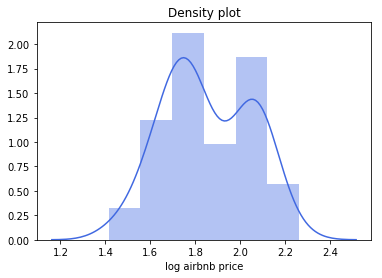

In [78]:
tmp = pd.concat([airbnb_agg_wo_outliers.loc[:, 'Air_log_price_Entire home/apt'],
                airbnb_agg_wo_outliers.loc[:, 'Air_log_price_Private room'],
                airbnb_agg_wo_outliers.loc[:, 'Air_log_price_Shared room']],
               ignore_index=True)
tmp.dropna(inplace=True)
ax = sns.distplot(tmp, color=col1)
ax.set_xlabel("log airbnb price")
ax.set_title("Density plot");

In [79]:
airbnb_agg_wo_outliers_sum = air.aggregate_data(airbnb_sub_wo_outliers, 
                                                ['Air_accommodates', 'Air_bathrooms', 'Air_bedrooms',
                                                 'Air_beds', 'Air_guests_included', 'Air_log_price'], 
                                                ['Air_neighbourhood_cleansed'], agg_fun ='sum',
                                                classifier='Air_room_type')
airbnb_agg_wo_outliers_sum.head(1)

,Air_neighbourhood_cleansed,Air_accommodates_Entire home/apt,Air_accommodates_Private room,Air_accommodates_Shared room,Air_bathrooms_Entire home/apt,Air_bathrooms_Private room,Air_bathrooms_Shared room,Air_bedrooms_Entire home/apt,Air_bedrooms_Private room,Air_bedrooms_Shared room,Air_beds_Entire home/apt,Air_beds_Private room,Air_beds_Shared room,Air_guests_included_Entire home/apt,Air_guests_included_Private room,Air_guests_included_Shared room,Air_log_price_Entire home/apt,Air_log_price_Private room,Air_log_price_Shared room
0,Banyule,196.0,164.0,8.0,78.0,99.5,5.0,91.0,93.0,5.0,108.0,105.0,8.0,95.0,93.0,5.0,133.858944,146.740989,8.213741


In [80]:
airbnb_agg_wo_outliers_count = air.aggregate_data(airbnb_sub_wo_outliers, 
                                                  ['Air_accommodates', 'Air_bathrooms', 'Air_bedrooms',
                                                   'Air_beds', 'Air_guests_included', 'Air_log_price'], 
                                                  ['Air_neighbourhood_cleansed'], agg_fun ='count',
                                                  classifier='Air_room_type')
airbnb_agg_wo_outliers_count.head(1)

,Air_neighbourhood_cleansed,Air_accommodates_Entire home/apt,Air_accommodates_Private room,Air_accommodates_Shared room,Air_bathrooms_Entire home/apt,Air_bathrooms_Private room,Air_bathrooms_Shared room,Air_bedrooms_Entire home/apt,Air_bedrooms_Private room,Air_bedrooms_Shared room,Air_beds_Entire home/apt,Air_beds_Private room,Air_beds_Shared room,Air_guests_included_Entire home/apt,Air_guests_included_Private room,Air_guests_included_Shared room,Air_log_price_Entire home/apt,Air_log_price_Private room,Air_log_price_Shared room
0,Banyule,67.0,87.0,5.0,67.0,87.0,5.0,67.0,87.0,5.0,67.0,87.0,5.0,67.0,87.0,5.0,67.0,87.0,5.0


In [81]:
133.858944/67 # this is what we have in airbnb_agg_wo_outliers in the correspondant column -> check passsed

1.9978946865671643

In [82]:
airbnb_agg_wo_outliers_var = air.aggregate_data(airbnb_sub_wo_outliers, 
                                                  ['Air_log_price'], 
                                                  ['Air_neighbourhood_cleansed'], agg_fun ='var',
                                                  classifier='Air_room_type')
airbnb_agg_wo_outliers_var.head(1)

,Air_neighbourhood_cleansed,Air_log_price_Entire home/apt,Air_log_price_Private room,Air_log_price_Shared room
0,Banyule,0.033342,0.0258,0.063067


In [83]:
pickle.dump(airbnb_agg_wo_outliers, open("airbnb_agg_wo_outliers.p", "wb"))
pickle.dump(airbnb_agg_wo_outliers_sum, open("airbnb_agg_wo_outliers_sum.p", "wb"))
pickle.dump(airbnb_agg_wo_outliers_count, open("airbnb_agg_wo_outliers_count.p", "wb"))
pickle.dump(airbnb_agg_wo_outliers_var, open("airbnb_agg_wo_outliers_var.p", "wb"))

In [84]:
airbnb_agg_wo_outliers = pickle.load(open("airbnb_agg_wo_outliers.p", "rb"))
airbnb_agg_wo_outliers_sum = pickle.load(open("airbnb_agg_wo_outliers_sum.p", "rb"))
airbnb_agg_wo_outliers_count = pickle.load(open("airbnb_agg_wo_outliers_count.p", "rb"))
airbnb_agg_wo_outliers_var = pickle.load(open("airbnb_agg_wo_outliers_var.p", "rb"))

*Property type*

Next, we distinguish between the different property types

In [85]:
airbnb_agg_wo_outliers_prop = air.aggregate_data(airbnb_sub_wo_outliers, 
                                                 ['Air_accommodates', 'Air_bathrooms', 'Air_bedrooms',
                                                 'Air_beds', 'Air_guests_included', 'Air_log_price'], 
                                                 ['Air_neighbourhood_cleansed'], agg_fun ='mean',
                                                 classifier = 'Air_property_type_2')
airbnb_agg_wo_outliers_prop 

,Air_neighbourhood_cleansed,Air_accommodates_Apartment_Condominium,Air_accommodates_House_Cottage_Villa,Air_accommodates_Other,Air_accommodates_Townhouse,Air_bathrooms_Apartment_Condominium,Air_bathrooms_House_Cottage_Villa,Air_bathrooms_Other,Air_bathrooms_Townhouse,Air_bedrooms_Apartment_Condominium,...,Air_beds_Other,Air_beds_Townhouse,Air_guests_included_Apartment_Condominium,Air_guests_included_House_Cottage_Villa,Air_guests_included_Other,Air_guests_included_Townhouse,Air_log_price_Apartment_Condominium,Air_log_price_House_Cottage_Villa,Air_log_price_Other,Air_log_price_Townhouse
0,Banyule,2.688889,2.087500,2.333333,2.400000,1.144444,1.150000,1.041667,1.400000,1.333333,...,1.375000,1.300000,1.311111,1.125000,1.416667,1.000000,1.960543,1.725312,1.875414,1.755435
1,Bayside,2.675000,2.606742,2.156250,3.269231,1.168750,1.337079,1.000000,1.346154,1.312500,...,1.218750,1.730769,1.200000,1.258427,1.343750,1.153846,2.035590,1.968721,1.963081,2.084166
2,Boroondara,2.458015,2.363128,2.452381,2.615385,1.095420,1.187151,1.095238,1.250000,1.179389,...,1.404762,1.615385,1.190840,1.184358,1.238095,1.423077,1.916158,1.855915,1.953877,1.929499
3,Brimbank,1.400000,2.105263,2.750000,2.111111,1.000000,1.245614,1.083333,1.055556,1.000000,...,1.583333,1.111111,1.200000,1.070175,1.333333,1.111111,1.771031,1.696429,1.822246,1.767104
4,Cardinia,2.000000,2.585366,2.790698,NaN,1.000000,1.036585,1.104651,NaN,1.000000,...,1.581395,NaN,1.000000,1.317073,1.325581,NaN,2.109008,1.932142,2.179095,NaN
5,Casey,3.000000,2.297619,2.250000,2.875000,1.000000,1.125000,1.031250,1.250000,1.333333,...,1.562500,1.625000,1.000000,1.166667,1.187500,1.375000,2.064753,1.811491,1.851419,1.971088
6,Darebin,2.518519,2.543103,2.250000,2.577465,1.087963,1.165948,1.035714,1.274648,1.208333,...,1.267857,1.394366,1.259259,1.150862,1.178571,1.169014,1.922047,1.821812,1.865129,1.876456
7,Frankston,2.571429,2.753623,2.416667,3.000000,1.047619,1.246377,1.104167,1.250000,1.190476,...,1.458333,1.833333,1.476190,1.260870,1.416667,1.333333,2.034363,1.859422,2.023561,1.981820
8,Glen Eira,2.469027,2.316667,2.090909,2.513514,1.101770,1.227778,1.121212,1.324324,1.269912,...,1.181818,1.297297,1.146018,1.144444,1.090909,1.135135,1.891682,1.846359,1.859811,1.900383
9,Greater Dandenong,1.666667,2.162500,2.333333,1.750000,1.222222,1.018750,0.916667,1.125000,1.222222,...,1.666667,1.312500,1.000000,1.100000,1.000000,1.000000,1.698004,1.696717,1.753280,1.765216


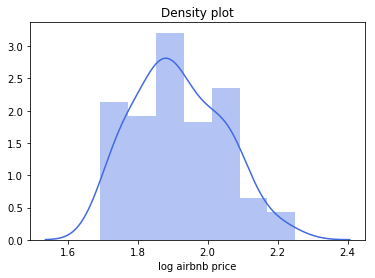

In [86]:
tmp = pd.concat([airbnb_agg_wo_outliers_prop.loc[:, 'Air_log_price_Apartment_Condominium'],
                airbnb_agg_wo_outliers_prop.loc[:, 'Air_log_price_House_Cottage_Villa'],
                airbnb_agg_wo_outliers_prop.loc[:, 'Air_log_price_Other'],
                airbnb_agg_wo_outliers_prop.loc[:, 'Air_log_price_Townhouse']],
               ignore_index=True)
tmp.dropna(inplace=True)
ax = sns.distplot(tmp, color=col1)
ax.set_xlabel("log airbnb price")
ax.set_title("Density plot");

In [87]:
airbnb_agg_wo_outliers_prop_sum = air.aggregate_data(airbnb_sub_wo_outliers, 
                                                     ['Air_accommodates', 'Air_bathrooms', 'Air_bedrooms',
                                                      'Air_beds', 'Air_guests_included', 'Air_log_price'], 
                                                     ['Air_neighbourhood_cleansed'], agg_fun ='sum',
                                                     classifier = 'Air_property_type_2')
airbnb_agg_wo_outliers_prop_sum.head(1) 

,Air_neighbourhood_cleansed,Air_accommodates_Apartment_Condominium,Air_accommodates_House_Cottage_Villa,Air_accommodates_Other,Air_accommodates_Townhouse,Air_bathrooms_Apartment_Condominium,Air_bathrooms_House_Cottage_Villa,Air_bathrooms_Other,Air_bathrooms_Townhouse,Air_bedrooms_Apartment_Condominium,...,Air_beds_Other,Air_beds_Townhouse,Air_guests_included_Apartment_Condominium,Air_guests_included_House_Cottage_Villa,Air_guests_included_Other,Air_guests_included_Townhouse,Air_log_price_Apartment_Condominium,Air_log_price_House_Cottage_Villa,Air_log_price_Other,Air_log_price_Townhouse
0,Banyule,121.0,167.0,56.0,24.0,51.5,92.0,25.0,14.0,60.0,...,33.0,13.0,59.0,90.0,34.0,10.0,88.224429,138.024947,45.009943,17.554355


In [88]:
airbnb_agg_wo_outliers_prop_count = air.aggregate_data(airbnb_sub_wo_outliers, 
                                                       ['Air_accommodates', 'Air_bathrooms', 'Air_bedrooms',
                                                        'Air_beds', 'Air_guests_included', 'Air_log_price'], 
                                                       ['Air_neighbourhood_cleansed'], agg_fun ='count',
                                                       classifier = 'Air_property_type_2')
airbnb_agg_wo_outliers_prop_count.head(1)

,Air_neighbourhood_cleansed,Air_accommodates_Apartment_Condominium,Air_accommodates_House_Cottage_Villa,Air_accommodates_Other,Air_accommodates_Townhouse,Air_bathrooms_Apartment_Condominium,Air_bathrooms_House_Cottage_Villa,Air_bathrooms_Other,Air_bathrooms_Townhouse,Air_bedrooms_Apartment_Condominium,...,Air_beds_Other,Air_beds_Townhouse,Air_guests_included_Apartment_Condominium,Air_guests_included_House_Cottage_Villa,Air_guests_included_Other,Air_guests_included_Townhouse,Air_log_price_Apartment_Condominium,Air_log_price_House_Cottage_Villa,Air_log_price_Other,Air_log_price_Townhouse
0,Banyule,45.0,80.0,24.0,10.0,45.0,80.0,24.0,10.0,45.0,...,24.0,10.0,45.0,80.0,24.0,10.0,45.0,80.0,24.0,10.0


In [89]:
88.224429/45 # check passed

1.9605428666666667

In [90]:
airbnb_agg_wo_outliers_prop_var = air.aggregate_data(airbnb_sub_wo_outliers, 
                                                       ['Air_log_price'], 
                                                       ['Air_neighbourhood_cleansed'], agg_fun ='var',
                                                       classifier = 'Air_property_type_2')
airbnb_agg_wo_outliers_prop_var.head(1)

,Air_neighbourhood_cleansed,Air_log_price_Apartment_Condominium,Air_log_price_House_Cottage_Villa,Air_log_price_Other,Air_log_price_Townhouse
0,Banyule,0.048341,0.044267,0.040141,0.025176


In [91]:
pickle.dump(airbnb_agg_wo_outliers_prop, open("airbnb_agg_wo_outliers_prop.p", "wb"))
pickle.dump(airbnb_agg_wo_outliers_prop_sum, open("airbnb_agg_wo_outliers_prop_sum.p", "wb"))
pickle.dump(airbnb_agg_wo_outliers_prop_count, open("airbnb_agg_wo_outliers_prop_count.p", "wb"))
pickle.dump(airbnb_agg_wo_outliers_prop_var, open("airbnb_agg_wo_outliers_prop_var.p", "wb"))

In [92]:
airbnb_agg_wo_outliers_prop = pickle.load(open("airbnb_agg_wo_outliers_prop.p", "rb"))
airbnb_agg_wo_outliers_prop_sum = pickle.load(open("airbnb_agg_wo_outliers_prop_sum.p", "rb"))
airbnb_agg_wo_outliers_prop_count = pickle.load(open("airbnb_agg_wo_outliers_prop_count.p", "rb"))
airbnb_agg_wo_outliers_prop_var = pickle.load(open("airbnb_agg_wo_outliers_prop_var.p", "rb"))

**Circle with radius of 50, 100 and 500 meters**

Before aggregating the data, we store the values as numpy arrays.

In [93]:
airbnb_lat_long = airbnb_cleaned_df.loc[:, ['Air_latitude', 'Air_longitude']].values
airbnb_lat_long_2 = airbnb_sub_wo_outliers.loc[:, ['Air_latitude', 'Air_longitude']].values

In [94]:
airbnb_lat_long_2

array([[-37.77268393, 145.09213285],
       [-37.76650512, 144.9807361 ],
       [-37.85975502, 144.97736913],
       ...,
       [-37.87525158, 145.16275659],
       [-37.8277951 , 144.95498687],
       [-37.80518635, 144.9623991 ]])

To aggregate airbnb data around circles with respect to a dictionary storing the the observations, the function `aggregate_airbnb_data_circles()` is defined. In what follows, (1) the observations that are within a circle with radius of 50, 100 and 500 meters are selected and then (2) aggregated.

*This step is time-consuming and the cells are thus set to raw.*

In [95]:
airbnb_obs_50m_wo_outliers = pickle.load(open("airbnb_obs_50m_wo_outliers.p", "rb"))
airbnb_obs_100m_wo_outliers = pickle.load(open("airbnb_obs_100m_wo_outliers.p", "rb"))
airbnb_obs_500m_wo_outliers = pickle.load(open("airbnb_obs_500m_wo_outliers.p", "rb"))

In [96]:
len(airbnb_obs_500m_wo_outliers.keys()) # 22331

22331

*Check*

We check whether the selection of the observations went well by inspecting the distance to the reference object. The reference object is included but will be later removed for the aggregation. For the examples tested the distances are all below 500 meters (0.5 km), which means that the selection works.

In [97]:
airbnb_obs_500m_wo_outliers['0']

array([   0, 6667, 7080, 7081, 7097])

In [98]:
lat1, lon1 = airbnb_lat_long[0,]
for i in airbnb_obs_500m_wo_outliers['0']:
    lat2, lon2 = airbnb_lat_long_2[i,]
    print(air._haversine_np(lon1, lat1, lon2, lat2))

0.0
0.471731206906071
0.3628758582743597
0.3481227018582127
0.20352851422727503


In [99]:
airbnb_obs_500m_wo_outliers['1']

array([    1,   827,   906,  1578,  1812,  2422,  3628,  4185,  7920,
        9251,  9848, 10562, 11235, 14774, 17137])

In [100]:
lat1, lon1 = airbnb_lat_long[1,]
for i in airbnb_obs_500m_wo_outliers['1']:
    lat2, lon2 = airbnb_lat_long_2[i,]
    print(air._haversine_np(lon1, lat1, lon2, lat2))

0.0
0.18188448413633493
0.09037634655077148
0.26217340415297613
0.36917543155597216
0.290517372829226
0.23993239170653569
0.35729930507287405
0.037726305254716985
0.30272278976071454
0.2509458861195018
0.3454966593939581
0.42731186854567355
0.4951383686970796
0.4975254668419996


*Room type - extraction*

The information as e.g. the log price, number of accommodations or number of beds related to the observations are now aggreagated. The information related to the reference observations is not considered. The aggregations are done for the different room types.

*This step is time-consuming and the cells are thus set to raw.*

Save the results

Load the results

In [101]:
airbnb_agg_50m_wo_outliers = pickle.load(open("airbnb_agg_50m_wo_outliers.p", "rb"))
airbnb_agg_100m_wo_outliers = pickle.load(open("airbnb_agg_100m_wo_outliers.p", "rb"))
airbnb_agg_500m_wo_outliers = pickle.load(open("airbnb_agg_500m_wo_outliers.p", "rb"))

In [102]:
airbnb_agg_500m_wo_outliers['mean'].shape

(22066, 19)

*Property type - extraction*

We do the same for the different property types.

*This step is time-consuming and the cells are thus set to raw.*

In [103]:
airbnb_agg_50m_wo_outliers_prop = pickle.load(open("airbnb_agg_50m_wo_outliers_prop.p", "rb"))
airbnb_agg_100m_wo_outliers_prop = pickle.load(open("airbnb_agg_100m_wo_outliers_prop.p", "rb"))
airbnb_agg_500m_wo_outliers_prop = pickle.load(open("airbnb_agg_500m_wo_outliers_prop.p", "rb"))

**The price of the nearest accommodation**

Next, we want to select the price and other information of the nearest accommodation w.r.t the reference observation. Again, we do this for the room types and for the property types. First, the nearest neighbours are selected. The basis for the selection are the accommodations that are located within a radius of 500 meters to the reference object.

In [104]:
airbnb_lat_long = airbnb_cleaned_df.loc[:, ['Air_latitude', 'Air_longitude', 'Air_id']]
airbnb_lat_long_type = airbnb_sub_wo_outliers.loc[:, ['Air_latitude', 'Air_longitude', 
                                                      'Air_room_type', 'Air_property_type_2',
                                                      'Air_id']]

In [105]:
airbnb_lat_long.head(5)

,Air_latitude,Air_longitude,Air_id
0,-37.772684,145.092133,9835
1,-37.766505,144.980736,10803
2,-37.859755,144.977369,12936
3,-37.758971,144.989228,15246
4,-37.864530,144.992238,16760


In [106]:
airbnb_lat_long_type.head(5)

,Air_latitude,Air_longitude,Air_room_type,Air_property_type_2,Air_id
0,-37.772684,145.092133,Private room,House_Cottage_Villa,9835
1,-37.766505,144.980736,Private room,Apartment_Condominium,10803
2,-37.859755,144.977369,Entire home/apt,Apartment_Condominium,12936
3,-37.758971,144.989228,Private room,House_Cottage_Villa,15246
4,-37.864530,144.992238,Private room,House_Cottage_Villa,16760


*The next steps are time-consuming and the cells are thus set to raw.*

*Room type - selection*

We now select the nearest neigbours by taking into account the different room types.

In [107]:
airbnb_nearest_obs_wo_outliers = pickle.load(open("airbnb_nearest_obs_wo_outliers.p", "rb"))

*Check*

The checks below gives a hint that the procedure is working properly. We see that for the first obseration in the dataset we only have an accommodation with a private room. This is correct as the next cell shows.

In [108]:
airbnb_nearest_obs_wo_outliers['0']

{'Entire home/apt': None, 'Private room': 7097, 'Shared room': None}

In [109]:
airbnb_sub_wo_outliers.loc[airbnb_obs_500m_wo_outliers['0'], 'Air_room_type']

0       Private room
6667    Private room
7080    Private room
7081    Private room
7097    Private room
Name: Air_room_type, dtype: object

To be more sure we also do the check for the second observation on our dataset. Three room types are present and thus show up in `airbnb_nearest_obs_wo_outliers['1']`

In [110]:
airbnb_nearest_obs_wo_outliers['1']

{'Entire home/apt': 906, 'Private room': 7920, 'Shared room': 9251}

In [111]:
airbnb_sub_wo_outliers.loc[airbnb_obs_500m_wo_outliers['1'], 'Air_room_type']

1           Private room
827         Private room
906      Entire home/apt
1578     Entire home/apt
1812        Private room
2422        Private room
3628     Entire home/apt
4185     Entire home/apt
7920        Private room
9251         Shared room
9848     Entire home/apt
10562       Private room
11235       Private room
14774    Entire home/apt
17137       Private room
Name: Air_room_type, dtype: object

*Property type - selection*

The selection is done w.r.t the property types

In [112]:
airbnb_nearest_obs_wo_outliers_prop = pickle.load(open("airbnb_nearest_obs_wo_outliers_prop.p", "rb"))

In [113]:
airbnb_nearest_obs_wo_outliers_prop['0']

{'Other': None,
 'House_Cottage_Villa': 7097,
 'Apartment_Condominium': None,
 'Townhouse': None}

*Room type - extraction*

Next, the datasets with the prices of the nearest neighbours are created. We start with the room types. The distance to the reference observation is also extracted.

In [114]:
airbnb_nearest_price_wo_outliers = air.the_nearest_obs_prices(airbnb_cleaned_df, 
                                                              airbnb_sub_wo_outliers,
                                                              airbnb_nearest_obs_wo_outliers, 
                                                              ['Air_log_price', 'Air_accommodates', 
                                                               'Air_bathrooms', 'Air_bedrooms',
                                                               'Air_beds', 'Air_guests_included'],
                                                              classifier='Air_room_type',
                                                              distance=True)

In [115]:
airbnb_nearest_price_wo_outliers.head(5)

,Air_group,Air_log_price_Entire home/apt,Air_accommodates_Entire home/apt,Air_bathrooms_Entire home/apt,Air_bedrooms_Entire home/apt,Air_beds_Entire home/apt,Air_guests_included_Entire home/apt,Air_log_price_Private room,Air_accommodates_Private room,Air_bathrooms_Private room,...,Air_guests_included_Private room,Air_log_price_Shared room,Air_accommodates_Shared room,Air_bathrooms_Shared room,Air_bedrooms_Shared room,Air_beds_Shared room,Air_guests_included_Shared room,dist_Entire home/apt,dist_Private Room,dist_Shared Room
0,0,NaN,NaN,NaN,NaN,NaN,NaN,2.477121,1.0,1.0,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.203529,NaN
1,1,2.342423,4.0,1.0,2.0,2.0,1.0,1.662758,2.0,1.0,...,1.0,1.778151,2.0,1.5,1.0,1.0,1.0,0.090376,0.037726,0.302723
2,2,2.139879,2.0,1.0,1.0,1.0,1.0,1.633468,2.0,1.0,...,1.0,1.462398,1.0,1.0,1.0,1.0,1.0,0.009089,0.043751,0.493991
3,3,2.146128,4.0,1.5,3.0,3.0,3.0,1.698970,1.0,1.5,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.040289,0.031024,NaN
4,4,2.389166,4.0,1.0,2.0,2.0,1.0,1.623249,1.0,1.0,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.016198,0.025602,NaN


In [116]:
airbnb_nearest_price_wo_outliers.tail(5)

,Air_group,Air_log_price_Entire home/apt,Air_accommodates_Entire home/apt,Air_bathrooms_Entire home/apt,Air_bedrooms_Entire home/apt,Air_beds_Entire home/apt,Air_guests_included_Entire home/apt,Air_log_price_Private room,Air_accommodates_Private room,Air_bathrooms_Private room,...,Air_guests_included_Private room,Air_log_price_Shared room,Air_accommodates_Shared room,Air_bathrooms_Shared room,Air_bedrooms_Shared room,Air_beds_Shared room,Air_guests_included_Shared room,dist_Entire home/apt,dist_Private Room,dist_Shared Room
22326,22326,2.113943,3.0,1.0,1.0,1.0,3.0,1.903090,2.0,1.0,...,2.0,1.681241,1.0,1.0,1.0,1.0,1.0,0.125486,0.023809,0.107223
22327,22327,NaN,NaN,NaN,NaN,NaN,NaN,1.851258,2.0,1.0,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.237938,NaN
22328,22328,2.146128,5.0,1.0,3.0,3.0,1.0,1.556303,2.0,1.0,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.344546,0.075165,NaN
22329,22329,2.139879,3.0,1.0,2.0,2.0,3.0,1.924279,2.0,1.0,...,1.0,2.544068,1.0,2.0,1.0,1.0,1.0,0.055510,0.032023,0.114885
22330,22330,2.146128,4.0,1.0,2.0,2.0,1.0,1.698970,1.0,1.0,...,1.0,1.892095,1.0,1.0,1.0,1.0,1.0,0.020007,0.019543,0.103503


Let's check that there are no or only a few observations with distance zero. A lot of observations with a distance of zero would be a hint that the reference observations was not removed. We see that there are no zeros, so everything went fine.

In [117]:
(airbnb_nearest_price_wo_outliers['dist_Entire home/apt'] == 0).sum()

0

Next, we save the results to disk.

In [118]:
pickle.dump(airbnb_nearest_price_wo_outliers, open("airbnb_nearest_price_wo_outliers.p", "wb"))

In [119]:
airbnb_nearest_price_wo_outliers = pickle.load(open("airbnb_nearest_price_wo_outliers.p", "rb"))
airbnb_nearest_price_wo_outliers.head(5)

,Air_group,Air_log_price_Entire home/apt,Air_accommodates_Entire home/apt,Air_bathrooms_Entire home/apt,Air_bedrooms_Entire home/apt,Air_beds_Entire home/apt,Air_guests_included_Entire home/apt,Air_log_price_Private room,Air_accommodates_Private room,Air_bathrooms_Private room,...,Air_guests_included_Private room,Air_log_price_Shared room,Air_accommodates_Shared room,Air_bathrooms_Shared room,Air_bedrooms_Shared room,Air_beds_Shared room,Air_guests_included_Shared room,dist_Entire home/apt,dist_Private Room,dist_Shared Room
0,0,NaN,NaN,NaN,NaN,NaN,NaN,2.477121,1.0,1.0,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.203529,NaN
1,1,2.342423,4.0,1.0,2.0,2.0,1.0,1.662758,2.0,1.0,...,1.0,1.778151,2.0,1.5,1.0,1.0,1.0,0.090376,0.037726,0.302723
2,2,2.139879,2.0,1.0,1.0,1.0,1.0,1.633468,2.0,1.0,...,1.0,1.462398,1.0,1.0,1.0,1.0,1.0,0.009089,0.043751,0.493991
3,3,2.146128,4.0,1.5,3.0,3.0,3.0,1.698970,1.0,1.5,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.040289,0.031024,NaN
4,4,2.389166,4.0,1.0,2.0,2.0,1.0,1.623249,1.0,1.0,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.016198,0.025602,NaN


*Property type - selection*

The selection is also done for the property types.

In [120]:
airbnb_nearest_price_wo_outliers_prop = air.the_nearest_obs_prices(airbnb_cleaned_df, 
                                                          airbnb_sub_wo_outliers,
                                                          airbnb_nearest_obs_wo_outliers_prop, 
                                                          ['Air_log_price', 'Air_accommodates', 
                                                           'Air_bathrooms', 'Air_bedrooms',
                                                           'Air_beds', 'Air_guests_included'],
                                                          classifier='Air_property_type_2',
                                                          distance=True)

In [121]:
airbnb_nearest_price_wo_outliers_prop.head(5)

,Air_group,Air_log_price_Other,Air_accommodates_Other,Air_bathrooms_Other,Air_bedrooms_Other,Air_beds_Other,Air_guests_included_Other,Air_log_price_House_Cottage_Villa,Air_accommodates_House_Cottage_Villa,Air_bathrooms_House_Cottage_Villa,...,Air_log_price_Townhouse,Air_accommodates_Townhouse,Air_bathrooms_Townhouse,Air_bedrooms_Townhouse,Air_beds_Townhouse,Air_guests_included_Townhouse,dist_Other,dist_House_Cottage_Villa,dist_Apartment_Condominium,dist_Townhouse
0,0,NaN,NaN,NaN,NaN,NaN,NaN,2.477121,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.203529,NaN,NaN
1,1,1.949390,2.0,1.0,0.0,1.0,1.0,2.342423,4.0,1.0,...,1.662758,2.0,1.0,1.0,1.0,1.0,0.495138,0.090376,0.239932,0.037726
2,2,2.298853,3.0,1.0,1.0,2.0,1.0,1.954243,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.069935,0.193637,0.009089,NaN
3,3,1.698970,1.0,1.5,1.0,1.0,1.0,2.146128,4.0,1.5,...,1.851258,2.0,1.0,1.0,1.0,1.0,0.031024,0.040289,0.249163,0.114271
4,4,1.812913,2.0,1.0,1.0,1.0,1.0,2.389166,4.0,1.0,...,1.623249,1.0,1.0,1.0,1.0,1.0,0.222255,0.016198,0.034103,0.025602


We also save these results to disk.

In [122]:
pickle.dump(airbnb_nearest_price_wo_outliers_prop, open("airbnb_nearest_price_wo_outliers_prop.p", "wb"))

In [123]:
airbnb_nearest_price_wo_outliers_prop = pickle.load(open("airbnb_nearest_price_wo_outliers_prop.p", "rb"))
airbnb_nearest_price_wo_outliers_prop.head(5)

,Air_group,Air_log_price_Other,Air_accommodates_Other,Air_bathrooms_Other,Air_bedrooms_Other,Air_beds_Other,Air_guests_included_Other,Air_log_price_House_Cottage_Villa,Air_accommodates_House_Cottage_Villa,Air_bathrooms_House_Cottage_Villa,...,Air_log_price_Townhouse,Air_accommodates_Townhouse,Air_bathrooms_Townhouse,Air_bedrooms_Townhouse,Air_beds_Townhouse,Air_guests_included_Townhouse,dist_Other,dist_House_Cottage_Villa,dist_Apartment_Condominium,dist_Townhouse
0,0,NaN,NaN,NaN,NaN,NaN,NaN,2.477121,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.203529,NaN,NaN
1,1,1.949390,2.0,1.0,0.0,1.0,1.0,2.342423,4.0,1.0,...,1.662758,2.0,1.0,1.0,1.0,1.0,0.495138,0.090376,0.239932,0.037726
2,2,2.298853,3.0,1.0,1.0,2.0,1.0,1.954243,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.069935,0.193637,0.009089,NaN
3,3,1.698970,1.0,1.5,1.0,1.0,1.0,2.146128,4.0,1.5,...,1.851258,2.0,1.0,1.0,1.0,1.0,0.031024,0.040289,0.249163,0.114271
4,4,1.812913,2.0,1.0,1.0,1.0,1.0,2.389166,4.0,1.0,...,1.623249,1.0,1.0,1.0,1.0,1.0,0.222255,0.016198,0.034103,0.025602


**HOUSING MARKET**

Next, the housing log prices are aggregated in the same way as the airbnb log prices before.

**Aggregated by 'House_suburb'**

First, the house prices are aggregated by the suburbs.

In [124]:
housing_agg_wo_outliers = house.aggregate_data(housing_sub_wo_outliers, 
                                               ['House_log_price', 'House_rooms', 
                                                'House_distance', 'House_bedroom2',
                                                'House_bathroom', 'House_landsize'], 
                                               ['House_suburb'], agg_fun ='mean')
housing_agg_wo_outliers.head(5)

,House_suburb,House_log_price_h,House_log_price_t,House_log_price_u,House_rooms_h,House_rooms_t,House_rooms_u,House_distance_h,House_distance_t,House_distance_u,House_bedroom2_h,House_bedroom2_t,House_bedroom2_u,House_bathroom_h,House_bathroom_t,House_bathroom_u,House_landsize_h,House_landsize_t,House_landsize_u
0,abbotsford,6.077959,5.954243,5.773378,2.516129,3.000,1.800000,2.677419,2.500000,2.600000,2.548387,3.00,1.800000,1.290323,2.000000,1.400000,168.161290,0.000000,120.200000
1,aberfeldie,6.142158,6.048484,5.776457,3.500000,3.000,2.200000,8.500000,8.566667,8.780000,3.187500,3.00,2.200000,2.000000,2.333333,1.200000,567.562500,344.666667,302.800000
2,airport west,5.907171,5.848116,5.761186,3.103448,2.875,2.428571,11.896552,11.950000,12.171429,3.103448,2.75,2.428571,1.517241,1.750000,1.142857,493.586207,231.750000,169.142857
3,albanvale,5.732211,NaN,NaN,3.333333,NaN,NaN,14.000000,NaN,NaN,3.333333,NaN,NaN,1.000000,NaN,NaN,552.000000,NaN,NaN
4,albert park,6.229841,NaN,5.645913,2.640000,NaN,1.000000,3.228000,NaN,3.300000,2.520000,NaN,1.000000,1.400000,NaN,1.000000,137.400000,NaN,0.000000


In [125]:
housing_agg_wo_outliers_counts = house.aggregate_data(housing_sub_wo_outliers, 
                                                      ['House_log_price', 'House_rooms', 
                                                       'House_distance', 'House_bedroom2',
                                                       'House_bathroom', 'House_landsize'], 
                                                      ['House_suburb'], agg_fun ='count')
housing_agg_wo_outliers_counts.head(5)

,House_suburb,House_log_price_h,House_log_price_t,House_log_price_u,House_rooms_h,House_rooms_t,House_rooms_u,House_distance_h,House_distance_t,House_distance_u,House_bedroom2_h,House_bedroom2_t,House_bedroom2_u,House_bathroom_h,House_bathroom_t,House_bathroom_u,House_landsize_h,House_landsize_t,House_landsize_u
0,abbotsford,31.0,1.0,5.0,31.0,1.0,5.0,31.0,1.0,5.0,31.0,1.0,5.0,31.0,1.0,5.0,31.0,1.0,5.0
1,aberfeldie,16.0,3.0,5.0,16.0,3.0,5.0,16.0,3.0,5.0,16.0,3.0,5.0,16.0,3.0,5.0,16.0,3.0,5.0
2,airport west,29.0,8.0,7.0,29.0,8.0,7.0,29.0,8.0,7.0,29.0,8.0,7.0,29.0,8.0,7.0,29.0,8.0,7.0
3,albanvale,3.0,NaN,NaN,3.0,NaN,NaN,3.0,NaN,NaN,3.0,NaN,NaN,3.0,NaN,NaN,3.0,NaN,NaN
4,albert park,25.0,NaN,1.0,25.0,NaN,1.0,25.0,NaN,1.0,25.0,NaN,1.0,25.0,NaN,1.0,25.0,NaN,1.0


We save it to disk and then load the dataset.

In [126]:
pickle.dump(housing_agg_wo_outliers, open("housing_agg_wo_outliers.p", "wb"))
housing_agg_wo_outliers = pickle.load(open("housing_agg_wo_outliers.p", "rb"))

The most frequent `house_type` is 'h'. The log prices of the different house types are (linearly) related to each other so it might be possible to take into account only the prices of house type 'h' in our subsequent analysis and in order not to reduce the number of observations too much if needed. However, we will later try to match the information from the housing market such that the house type and the airbnb property type fit to each other. The house prices of townhouses (blue) and units/duplexes (orange) of different suburbs are related to the prices of houses, cottages/villas/terraces of the same suburbs as it is illustrated in the plot. 

In [127]:
housing_agg_wo_outliers.shape # (268, 19)
housing_agg_wo_outliers_sub = housing_agg_wo_outliers.dropna(how='any')
housing_agg_wo_outliers_sub.shape # (128, 19)

(128, 19)

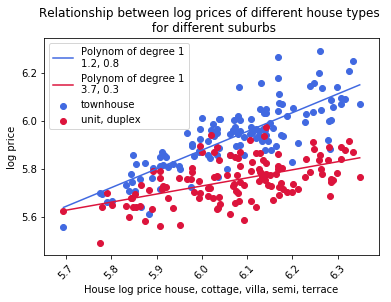

In [128]:
y1 = housing_agg_wo_outliers_sub.House_log_price_t
y2 = housing_agg_wo_outliers_sub.House_log_price_u
x = housing_agg_wo_outliers_sub.House_log_price_h
deg = 1
res1 = polynomial(x, y1, deg)
res2 = polynomial(x, y2, deg)

plt.scatter(housing_agg_wo_outliers_sub.House_log_price_h, housing_agg_wo_outliers_sub.House_log_price_t, 
            label='townhouse', color=col1)
plt.plot(res1['data'].x_1, res1['data'].y_pred, color=col1, label="Polynom of degree " + str(deg) + 
            '\n' + res1['coef'])
plt.legend()

plt.scatter(housing_agg_wo_outliers_sub.House_log_price_h, housing_agg_wo_outliers_sub.House_log_price_u, 
            label='unit, duplex', color=col2)
plt.plot(res2['data'].x_1, res2['data'].y_pred, color=col2, label="Polynom of degree " + str(deg) + 
            '\n' + res2['coef'])
plt.legend()
plt.xlabel('House log price house, cottage, villa, semi, terrace')
plt.ylabel('log price')
plt.title('Relationship between log prices of different house types \n for different suburbs')
plt.xticks(rotation=45)
plt.legend();

**Aggregated housing data around airbnb accommodations**

We want to aggregate the housing prices around airbnb accommodations in a similar way as we have already aggregated the airbnb accommodations.

In [129]:
airbnb_lat_long = airbnb_cleaned_df.loc[:, ['Air_latitude', 'Air_longitude']].values
housing_lat_long = housing_sub_wo_outliers.loc[:, ['House_latitude', 'House_longitude']].values

**Circle with radius of 0.5, 1 and 5 km**

Next, the observations that are going to be aggregated in a later step are selected.

*This step is time-consuming and the cells are thus set to Raw.*

We load the datasets again.

In [130]:
housing_obs_500m_wo_outliers = pickle.load(open("housing_obs_500m_wo_outliers.p", "rb"))
housing_obs_1km_wo_outliers = pickle.load(open("housing_obs_1km_wo_outliers.p", "rb"))
housing_obs_5km_wo_outliers = pickle.load(open("housing_obs_5km_wo_outliers.p", "rb"))

In a next step, the data is aggregated based on the information in `housing_obs_500m_wo_outliers`, `housing_obs_1km_wo_outliers` and `housing_obs_5km_wo_outliers`.

*This step is time-consuming and the cells are thus set to Raw.*

In [131]:
housing_agg_500m_wo_outliers = pickle.load(open("housing_agg_500m_wo_outliers.p", "rb"))
housing_agg_1km_wo_outliers = pickle.load(open("housing_agg_1km_wo_outliers.p", "rb"))
housing_agg_5km_wo_outliers = pickle.load(open("housing_agg_5km_wo_outliers.p", "rb"))

In [132]:
housing_agg_5km_wo_outliers['mean'].head(5)

,Air_group,House_log_price_h,House_log_price_t,House_log_price_u,House_rooms_h,House_rooms_t,House_rooms_u,House_distance_h,House_distance_t,House_distance_u,House_bedroom2_h,House_bedroom2_t,House_bedroom2_u,House_bathroom_h,House_bathroom_t,House_bathroom_u,House_landsize_h,House_landsize_t,House_landsize_u
0,0,6.142970,5.989953,5.810940,3.608833,2.897959,2.228571,10.881703,10.179592,10.228571,3.555205,2.918367,2.242857,1.876972,1.734694,1.185714,666.823344,217.530612,225.728571
1,1,6.074204,5.909904,5.721474,2.974811,2.629213,1.818584,5.791184,5.741573,4.725221,2.944584,2.617978,1.823009,1.403023,1.595506,1.115044,348.482368,163.426966,126.694690
2,2,6.198379,6.104796,5.792660,2.814136,2.678571,1.847701,4.676440,4.707143,4.942241,2.790576,2.678571,1.841954,1.531414,1.857143,1.209770,241.486911,144.535714,131.071839
3,3,6.052395,5.902187,5.700610,2.972940,2.623529,1.797980,6.449815,6.288235,5.861616,2.948339,2.611765,1.803030,1.380074,1.600000,1.065657,376.191882,140.835294,147.000000
4,4,6.209912,6.077968,5.784843,2.856410,2.676471,1.847262,5.361026,6.073529,5.310086,2.835897,2.676471,1.844380,1.564103,1.735294,1.184438,279.305128,139.294118,128.074928


In [133]:
housing_agg_5km_wo_outliers['mean'].tail(5)

,Air_group,House_log_price_h,House_log_price_t,House_log_price_u,House_rooms_h,House_rooms_t,House_rooms_u,House_distance_h,House_distance_t,House_distance_u,House_bedroom2_h,House_bedroom2_t,House_bedroom2_u,House_bathroom_h,House_bathroom_t,House_bathroom_u,House_landsize_h,House_landsize_t,House_landsize_u
21305,22325,6.141625,6.005488,5.773539,2.733202,2.500000,1.785933,3.098814,2.898276,3.047706,2.699605,2.482759,1.785933,1.430830,1.672414,1.262997,192.887352,186.465517,75.314985
21306,22326,6.122250,5.972390,5.757321,2.842713,2.556962,1.792398,3.755267,3.530380,3.223392,2.805195,2.544304,1.804094,1.417027,1.696203,1.228070,239.756133,174.189873,99.640351
21307,22328,6.100730,5.928096,5.891823,3.681481,3.000000,2.500000,14.798519,13.427273,14.307143,3.651852,3.000000,2.500000,1.748148,1.818182,1.214286,672.711111,285.181818,266.928571
21308,22329,6.145255,6.024018,5.782202,2.706150,2.509434,1.791798,3.053986,2.875472,3.071293,2.676538,2.509434,1.788644,1.441913,1.679245,1.258675,185.289294,175.056604,90.564669
21309,22330,6.128658,5.974416,5.765363,2.828909,2.551282,1.804665,3.649115,3.478205,3.168513,2.792035,2.538462,1.816327,1.415929,1.692308,1.241983,235.423304,174.038462,94.638484


**The price of the nearest house sold**

The selection of the nearest house sold is implemented next.

In [134]:
housing_lat_long = housing_cleaned_df.loc[:, ['House_latitude', 'House_longitude']]
housing_lat_long_type = housing_sub_wo_outliers.loc[:, ['House_latitude', 'House_longitude', 'House_type']]

*This step is time-consuming and the cells are thus set to Raw.*

In [135]:
housing_nearest_obs_wo_outliers = pickle.load(open("housing_nearest_obs_wo_outliers.p", "rb"))

In [136]:
housing_nearest_price_wo_outliers = house.the_nearest_obs_housing_prices(airbnb_cleaned_df,
                                                                         housing_sub_wo_outliers, 
                                                                         housing_nearest_obs_wo_outliers, 
                                                                         ['House_log_price', 'House_rooms', 
                                                                          'House_distance', 'House_bedroom2',
                                                                          'House_bathroom', 'House_landsize'])

In [137]:
housing_nearest_price_wo_outliers.head(5)

,Air_group,House_log_price_h,House_rooms_h,House_distance_h,House_bedroom2_h,House_bathroom_h,House_landsize_h,House_log_price_u,House_rooms_u,House_distance_u,...,House_landsize_u,House_log_price_t,House_rooms_t,House_distance_t,House_bedroom2_t,House_bathroom_t,House_landsize_t,dist_h,dist_u,dist_t
0,0,6.325926,3.0,7.3,3.0,2.0,664.0,5.781755,2.0,7.5,...,0.0,6.100371,3.0,7.5,3.0,2.0,284.0,4.836398,4.497558,4.699588
1,1,6.012837,2.0,2.5,2.0,1.0,172.0,5.875061,2.0,2.5,...,0.0,5.954243,3.0,2.5,3.0,2.0,0.0,4.833653,4.793180,4.938525
2,2,6.181844,3.0,2.6,3.0,1.0,248.0,5.640978,1.0,2.6,...,778.0,6.130334,2.0,1.3,2.0,2.0,87.0,4.798061,4.986905,4.751524
3,3,6.213518,3.0,3.0,3.0,1.0,142.0,5.698970,2.0,2.5,...,0.0,5.916454,3.0,3.4,3.0,3.0,67.0,4.987677,4.777657,4.049423
4,4,6.191730,3.0,2.6,3.0,2.0,189.0,5.799341,2.0,2.4,...,0.0,6.155336,2.0,2.6,2.0,2.0,153.0,4.980823,4.984765,4.986148


We also save these results to disk and re-load them.

In [138]:
pickle.dump(housing_nearest_price_wo_outliers, open("housing_nearest_price_wo_outliers.p", "wb"))

In [139]:
housing_nearest_price_wo_outliers = pickle.load(open("housing_nearest_price_wo_outliers.p", "rb"))
housing_nearest_price_wo_outliers.head(5)

,Air_group,House_log_price_h,House_rooms_h,House_distance_h,House_bedroom2_h,House_bathroom_h,House_landsize_h,House_log_price_u,House_rooms_u,House_distance_u,...,House_landsize_u,House_log_price_t,House_rooms_t,House_distance_t,House_bedroom2_t,House_bathroom_t,House_landsize_t,dist_h,dist_u,dist_t
0,0,6.325926,3.0,7.3,3.0,2.0,664.0,5.781755,2.0,7.5,...,0.0,6.100371,3.0,7.5,3.0,2.0,284.0,4.836398,4.497558,4.699588
1,1,6.012837,2.0,2.5,2.0,1.0,172.0,5.875061,2.0,2.5,...,0.0,5.954243,3.0,2.5,3.0,2.0,0.0,4.833653,4.793180,4.938525
2,2,6.181844,3.0,2.6,3.0,1.0,248.0,5.640978,1.0,2.6,...,778.0,6.130334,2.0,1.3,2.0,2.0,87.0,4.798061,4.986905,4.751524
3,3,6.213518,3.0,3.0,3.0,1.0,142.0,5.698970,2.0,2.5,...,0.0,5.916454,3.0,3.4,3.0,3.0,67.0,4.987677,4.777657,4.049423
4,4,6.191730,3.0,2.6,3.0,2.0,189.0,5.799341,2.0,2.4,...,0.0,6.155336,2.0,2.6,2.0,2.0,153.0,4.980823,4.984765,4.986148


##### Crimes data 

Lastly, the crime dataset is aggregated. The aggregation is done according to the variable `local_government_area`.

In [140]:
crimes_agg = crime.aggregate_data(crime_cleaned_df, 
                                  ['Crime_lga_rate_per_100000_population'], 
                                  ['Crime_local_government_area'], 
                                   'Crime_offence_division', 
                                  agg_fun ='mean')
crimes_agg.head(5)

,Crime_local_government_area,Crime_lga_rate_per_100000_population_A Crimes against the person,Crime_lga_rate_per_100000_population_B Property and deception offences,Crime_lga_rate_per_100000_population_C Drug offences,Crime_lga_rate_per_100000_population_D Public order and security offences,Crime_lga_rate_per_100000_population_E Justice procedures offences,Crime_lga_rate_per_100000_population_F Other offences
0,alpine,43.445771,53.218761,52.839712,45.959223,35.907003,15.800766
1,ararat,46.929150,59.552030,49.278554,60.350185,53.386668,14.460237
2,ballarat,34.360020,43.748209,36.257205,25.038832,36.016893,2.420531
3,banyule,31.869290,40.475767,29.231876,14.929186,25.204392,1.677447
4,bass coast,47.467709,49.145052,45.218913,33.932810,36.492349,9.023037


In [141]:
crimes_agg_median = crime.aggregate_data(crime_cleaned_df, 
                                         ['Crime_lga_rate_per_100000_population'], 
                                         ['Crime_local_government_area'], 
                                         'Crime_offence_division', 
                                         agg_fun ='median')
crimes_agg_median.head(5)

,Crime_local_government_area,Crime_lga_rate_per_100000_population_A Crimes against the person,Crime_lga_rate_per_100000_population_B Property and deception offences,Crime_lga_rate_per_100000_population_C Drug offences,Crime_lga_rate_per_100000_population_D Public order and security offences,Crime_lga_rate_per_100000_population_E Justice procedures offences,Crime_lga_rate_per_100000_population_F Other offences
0,alpine,24.671053,40.873048,39.952058,24.646327,16.572754,8.271983
1,ararat,34.056800,51.085201,26.487727,43.308792,43.009141,8.829242
2,ballarat,15.012460,13.130539,16.362954,9.160871,18.615763,1.970327
3,banyule,15.269384,27.128381,9.277801,6.515719,11.383687,0.816237
4,bass coast,26.298104,33.472193,32.479132,19.335146,15.700066,3.501278


We save and load this dataset.

In [142]:
pickle.dump(crimes_agg, open("crimes_agg.p", "wb"))
pickle.dump(crimes_agg_median, open("crimes_agg_median.p", "wb"))
crimes_agg = pickle.load(open("crimes_agg.p", "rb"))
crimes_agg_median = pickle.load(open("crimes_agg_median.p", "rb"))